In [18]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import numpy as np
import random
from data_loader import NEFGSet


In [19]:
"""
Determine if any GPUs are available
"""
if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps" # Apple GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

print(f"Using device: {device}")



dataset = NEFG3x3Set("info_dat_std_NEGFXY.csv",
                     "data/3x12_16_damp00", "dat_std")

length = len(dataset)
train_split = math.floor(length*.7)
test_split = length - train_split
batch_size = 50
train_inds, test_inds = torch.utils.data.random_split(
    dataset, [train_split, test_split], generator=torch.Generator().manual_seed(42))
train_data = torch.utils.data.DataLoader(dataset=train_inds, batch_size=batch_size,
                                         shuffle=True)
test_data = torch.utils.data.DataLoader(dataset=test_inds, batch_size=batch_size,
                                        shuffle=True)


Using device: mps


In [20]:
"""
A Convolutional Variational Autoencoder
"""
class VAE(nn.Module):
    # ther og net had 128 final channels
    def __init__(self, imgChannels=3, layers = [16,32,64,64]):
        super(VAE, self).__init__()

        modules = []
        inChannels = imgChannels
        outChannels = layers[0]
        for i in layers:
            modules.append(
                nn.Sequential(
                nn.Conv2d(in_channels=inChannels, out_channels=i, kernel_size=5),
                nn.BatchNorm2d(i),
                nn.Dropout(0.3),
                nn.LeakyReLU()
                )
            )
            inChannels = i

        self.encoder = nn.Sequential(*modules)

        self.mu = nn.Conv2d(inChannels,inChannels, 1)
        self.logVar = nn.Conv2d(inChannels,inChannels, 1)
        self.short = nn.Conv2d(imgChannels, 1, 1)

        modules = []
        layers.reverse()
        for i in range(len(layers)-1):
            inChannels = layers[i]
            outChannels = layers[i+1]
            modules.append(
                nn.Sequential(
                nn.ConvTranspose2d(in_channels=inChannels, out_channels=outChannels, kernel_size=5),
                nn.BatchNorm2d(outChannels),
                nn.Dropout(0.3),
                nn.ReLU()
                )
            )
        modules.append(
                nn.Sequential(
                nn.ConvTranspose2d(in_channels=layers[-1], out_channels=1, kernel_size=5),
                )
            )
        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        logVar = self.logVar(x)
        return mu,logVar

    def decode(self, z):
        return self.decoder(z)
    
    def reparamaterize(self, mu, logVar):
        std = torch.exp(0.5 * logVar)
        eps = Variable(torch.randn_like(std))
        return eps * std + mu
        
    def forward(self, x):
        # mu,logVar = self.encode(x)
        # z = self.reparamaterize(mu,logVar)
        # out = torch.add(self.decode(z),x[:,0,...].unsqueeze(1))
        # out = torch.add(self.decode(self.encoder(x)),self.short(x))
        # out = self.decode(self.encoder(x))
        out = torch.add(self.decode(self.encoder(x)),x[:,0,...].unsqueeze(1))
        return out

In [21]:

net = VAE(imgChannels=7).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 500
loss = 0
kl_divergence1 = 0
min_loss = 1000
l1=0

for epoch in range(num_epochs):
    loss1 = 0
    kl_divergence1 = 0
    net.train()
    for idx, data in enumerate(train_data, 0):
        out = net(data[0])
        
        # kl_divergence = batch_size *0.5* torch.mean(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.mse_loss(out, data[3].unsqueeze(1))# + kl_divergence
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss1 += loss.item()
        # kl_divergence1+=kl_divergence
    loss1 = loss1/len(test_data)
    # kl_divergence1=kl_divergence1/len(test_data)
    # print(kl_divergence1)
    print('Epoch {}: Train Loss {}'.format(epoch,loss1))
    l2=0
    net.eval()
    for data in test_data:
        out = net(data[0])    
        if epoch == 1:
            cmp = data[1]
            # print((data[3].shape))
            l1+=F.mse_loss(data[3], cmp)
        l2+=F.mse_loss(data[3].unsqueeze(1), out)
    if l2<min_loss:
        min_loss = l2
        torch.save(net.state_dict(),"trained_run2.sd")
    if epoch == 1:
        print("CMP:", l1)
    print("out:", l2)

# Epoch 15: Train Loss 0.36227205101 kl-div 0-1
# 
# Epoch 15: Train Loss 0.99161257338 kl-div std

# Epoch 15: Train Loss 0.30827124285 kl-div std

# Use 0-1 data - yes
# Use whole range for layer 6 - X
# Remove charge just use pot

# Epoch 7: Train Loss 0.0947228386425055
# Epoch 7: Train Loss 0.0694243241674625

KeyboardInterrupt: 

CMP: 0
out: 0
inp: 0


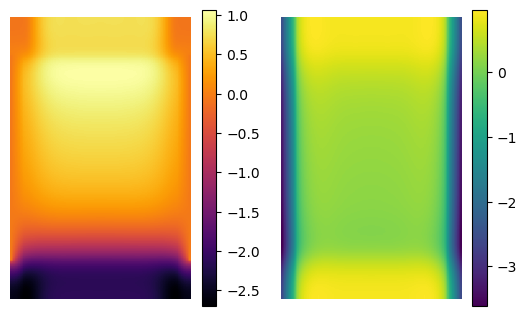

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import random
l2=0
l1=0
l3=0

fig, ax = plt.subplots(ncols=2)

with torch.no_grad():
    for data in test_data:         
        cmp = data[0][23][0]
        a = ax[0].imshow(cmp.cpu(), cmap="inferno")
        # y = np.linspace(0,cmp.shape[0],7)[1:-1]
        # x = np.linspace(0,cmp.shape[1],5)[1:-1]
        # ax[0].hlines(y,0,cmp.shape[1]-1, colors='white')
        # ax[0].vlines(x,0,cmp.shape[0]-1 ,colors='white')
        # for i,x in enumerate(np.linspace(0,cmp.shape[1]-1, 9)[1::2]):
        #     for y in np.linspace(0,cmp.shape[0]-1, 13)[1::2]:
        #         ax[0].annotate(str(round(i/3,2)),[x,y],xytext=(-10, -3), textcoords='offset points', color='white', weight="bold")
                
        ax[0].axis('off')
        fig.colorbar(a, ax=ax[0],shrink=0.8)
        cmp = data[0][23][1]
        b = ax[1].imshow(cmp.cpu())#, cmap="inferno")
        # y = np.linspace(0,cmp.shape[0],7)[1:-1]
        # x = np.linspace(0,cmp.shape[1],5)[1:-1]
        # ax[1].hlines(y,0,cmp.shape[1]-1, colors='white')
        # ax[1].vlines(x,0,cmp.shape[0]-1 ,colors='white')
        # for x in np.linspace(0,cmp.shape[1]-1, 9)[1::2]:
        #     for i,y in enumerate(np.linspace(0,cmp.shape[0]-1, 13)[1::2]):
        #         ax[1].annotate(str(round(i/5,2)),[x,y],xytext=(-7, -3), textcoords='offset points', color='white', weight="bold")
                
        ax[1].axis('off')
        fig.colorbar(b, ax=ax[1],shrink=0.8)
        
        
        plt.savefig("potc.pdf",  format="pdf",bbox_inches="tight", pad_inches=0)
        break
        # # print((data[3].shape))
        # l1+=F.mse_loss(data[3], cmp)
        # l2+=F.mse_loss(data[3].unsqueeze(1), out)
        # plt.imshow(out[3].squeeze().cpu())
        # plt.show()

        # plt.imshow(data[3][3].cpu())
        # plt.show()
        # break
        # l3+=F.l1_loss(data[3], data[0][0].unsqueeze(1))

print("CMP:", l1)
print("out:", l2)
print("inp:", l3)

# 0.0021

In [ ]:
print(min_loss)